In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import warnings
warnings.filterwarnings('ignore')

## 天池比赛的链接：https://tianchi.aliyun.com/competition/entrance/231573/information

In [3]:
data_user = pd.read_csv('user_balance_table.csv')
data_user['report_date'] = pd.to_datetime(data_user['report_date'], format='%Y%m%d')
data_user.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,2014-08-05,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,2014-08-08,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,2014-08-11,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,2014-08-14,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,2014-08-17,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


## 我们的目标
- 预测后30天的申购总额
- 预测后30天的赎回总额

## 说人话
#### 预测 ’total_purchase_amt‘，'total_redeem_amt' 这两个字段后30天的值

In [4]:
data_user_byday = data_user.groupby(['report_date'])['total_purchase_amt','total_redeem_amt'].sum().sort_values(['report_date']).reset_index()
data_user_byday.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2013-07-01,32488348,5525022
1,2013-07-02,29037390,2554548
2,2013-07-03,27270770,5953867
3,2013-07-04,18321185,6410729
4,2013-07-05,11648749,2763587


In [ ]:
##

In [5]:
#定义模型
def FB(data: pd.DataFrame) -> pd.DataFrame:
    
    df = pd.DataFrame({
    'ds': data.report_date,
    'y': data.total_purchase_amt,
    })
    
    df['cap'] = data.total_purchase_amt.values.max()
    df['floor'] = data.total_purchase_amt.values.min()

    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期性
        growth="logistic",
    )
    
#     m.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=0.1)#月周期性
    m.add_country_holidays(country_name='CN')#中国所有的节假日    
    
    m.fit(df)
    
    future = m.make_future_dataframe(periods=30, freq='D')#预测时长
    future['cap'] = data.total_purchase_amt.values.max()
    future['floor'] = data.total_purchase_amt.values.min()

    forecast = m.predict(future)
    
    fig = m.plot_components(forecast)
    fig1 = m.plot(forecast)
    
    return forecast

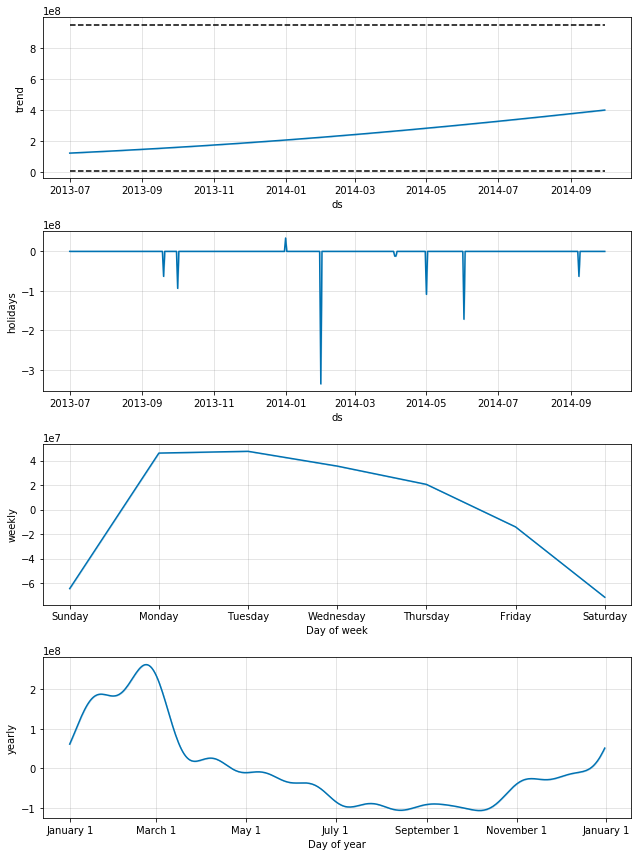

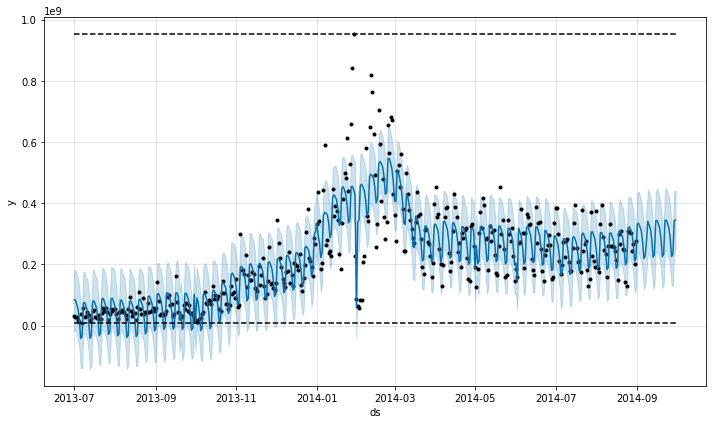

In [6]:
result_purchase = FB(data_user_byday)

In [7]:
#定义模型
def FB(data: pd.DataFrame) -> pd.DataFrame:
    
    df = pd.DataFrame({
    'ds': data.report_date,
    'y': data.total_redeem_amt,
    })
    
    df['cap'] = data.total_redeem_amt.values.max()
    df['floor'] = data.total_redeem_amt.values.min()

    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期性
        growth="logistic",
    )
    
    m.add_country_holidays(country_name='CN')#中国所有的节假日    
    
    m.fit(df)
    
    future = m.make_future_dataframe(periods=30, freq='D')#预测时长
    future['cap'] = data.total_redeem_amt.values.max()
    future['floor'] = data.total_redeem_amt.values.min()

    forecast = m.predict(future)
    
    fig = m.plot_components(forecast)
    fig1 = m.plot(forecast)
    
    return forecast

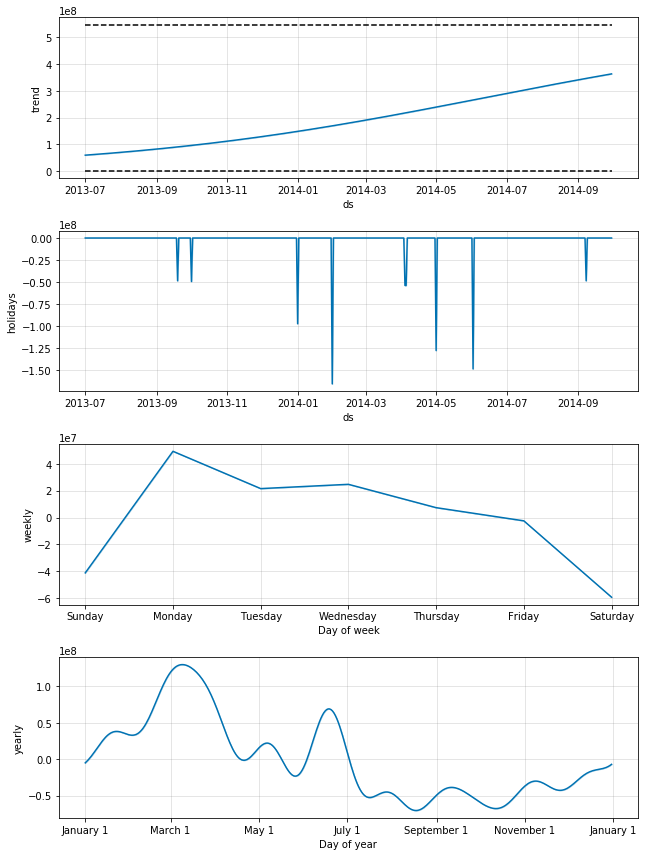

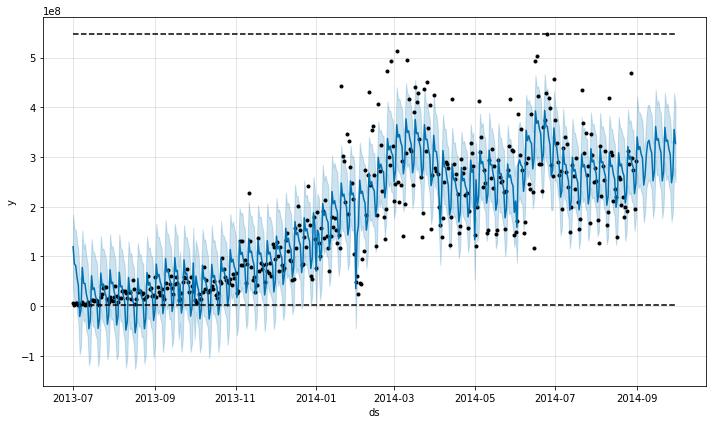

In [8]:
result_redeem = FB(data_user_byday)

In [9]:
result_purchase.tail()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,Chinese New Year,Chinese New Year_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
452,2014-09-26,3.972641e+08,952479658,8962232,1.828369e+08,3.876925e+08,3.972641e+08,3.972642e+08,0.0,0.0,...,-1.408823e+07,-1.408823e+07,-1.408823e+07,-9.988456e+07,-9.988456e+07,-9.988456e+07,0.0,0.0,0.0,2.832913e+08
453,2014-09-27,3.980910e+08,952479658,8962232,1.283048e+08,3.254861e+08,3.980910e+08,3.980910e+08,0.0,0.0,...,-7.149263e+07,-7.149263e+07,-7.149263e+07,-1.006909e+08,-1.006909e+08,-1.006909e+08,0.0,0.0,0.0,2.259075e+08
454,2014-09-28,3.989184e+08,952479658,8962232,1.325779e+08,3.334691e+08,3.989183e+08,3.989184e+08,0.0,0.0,...,-6.445946e+07,-6.445946e+07,-6.445946e+07,-1.015019e+08,-1.015019e+08,-1.015019e+08,0.0,0.0,0.0,2.329570e+08
455,2014-09-29,3.997462e+08,952479658,8962232,2.421303e+08,4.390657e+08,3.997462e+08,3.997463e+08,0.0,0.0,...,4.619189e+07,4.619189e+07,4.619189e+07,-1.023070e+08,-1.023070e+08,-1.023070e+08,0.0,0.0,0.0,3.436312e+08
456,2014-09-30,4.005747e+08,952479658,8962232,2.489140e+08,4.426664e+08,4.005746e+08,4.005747e+08,0.0,0.0,...,4.763959e+07,4.763959e+07,4.763959e+07,-1.030931e+08,-1.030931e+08,-1.030931e+08,0.0,0.0,0.0,3.451211e+08


In [10]:
data_comp =pd.read_csv('comp_predict_table.csv', header = None)
data_comp.head()

,0,1,2
0,20140901,40000000,30000000
1,20140902,40000000,30000000
2,20140903,40000000,30000000


In [11]:
data_day = []
for i in range(20140901,20140931):
    data_day.append(i)
# data_day

In [12]:
data_comp = pd.DataFrame(columns=[0, 1, 2])

In [13]:
data_comp[0] = data_day
data_comp[1] = result_purchase.yhat.values[-30:]
data_comp[2] = result_redeem.yhat.values[-30:]
data_comp

,0,1,2
0,20140901,3.315608e+08,3.403371e+08
1,20140902,3.343494e+08,3.152301e+08
2,20140903,3.235090e+08,3.209521e+08
3,20140904,3.096908e+08,3.059635e+08
4,20140905,2.759714e+08,2.983661e+08
5,20140906,2.194693e+08,2.435358e+08
6,20140907,2.273075e+08,2.634809e+08
7,20140908,2.754175e+08,3.070736e+08
8,20140909,3.407568e+08,3.292587e+08
9,20140910,3.292510e+08,3.336473e+08


In [14]:
data_comp.to_csv('tc_comp_predict_table.csv', header = None, index = False)